In [ ]:
!pip install tushare
import tushare as ts
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import requests
import pandas as pd
#!pip install -U "ray[default]"
!pip install gymnasium
#!pip install 'ray[rllib]'
!pip install 'ray[all]'
import gymnasium
from gymnasium import spaces
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.misc import SlimFC
import math
from collections import deque
from datetime import datetime, timedelta
from os import close
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPO  # Import PPOTrainer
from ray.rllib.algorithms.ppo import PPOConfig
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.misc import SlimFC
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import EnvContext
from ray.tune.registry import register_env
np.random.seed(135)
torch.manual_seed(135)

Setup Env

In [ ]:
class PortfolioOptimizationEnv(gymnasium.Env):
    '''
    Environment setting with OpenAI

    Assumptions:
    1. In this case, the team has loose the constrain of 24 hours holding period. Once a person buy in the stock, the person can sell it immediately
    2. We have simplified the buy order mechanism so that stocks can be bought at the closing price of the day in this environment.

    State: A stack of stock price data, stock index data, current stock volums, current cash amount
    Observation: Same with state but in a 365 trading days duration
    Action: A float list with a length of N (number of stocks chosen) which elements are within range (-1,1). When positive -> buy Ni * cash amount of stock i. When negtive -> sell Ni present of stocki's volume

    '''

    def __init__(self,env_config):
        super(PortfolioOptimizationEnv, self).__init__()
        try:
            self.history_length = env_config['history_length']
            self.start = env_config['start']                        #define start date
            self.end = env_config['end']                            #define end date
            self.market = env_config['market']                      #define market -> currently only China
            self.n_stock = env_config['n_stock']                    #define the number of stock chosen
            self.cash = env_config['cash']                          #define the initial cash we take into the market
            self.smoothing_factor = env_config['smoothing_factor']  #define smooth for the DSR reward function

            self.market_data = self.load_market_data(self.start, self.end, self.market)         #Initialize market data during the start to end -> execute once to shorten running time
            self.close_data = self.load_full_close_data(self.start, self.end, self.market)      #Initialize close data

            self.stock_tensor_length = self.market_data.shape[1] - 1                                    #See observation_space
            self.date_list = self.load_trading_days(self.start, self.end, self.market)                  #Filter trading days from the period
            self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_stock,), dtype=np.float32)     #define action space, please see 'Action' in the class comment for detail
            self.observation_space = spaces.Box(                                                        #define observation space as required by Rllib, the observation space have to be a flattened np list
                low=-np.inf, high=np.inf,                                                               #Thus the dimension is calcualted as shape
                shape=(self.history_length * (self.stock_tensor_length + self.n_stock + 1 + self.n_stock + 1),),
                dtype=np.float32
            )

            self.state_buffer = deque(maxlen=self.history_length)           #define state deque
            self.initial_cash = np.float32(self.cash)                       #define cash buffer
            self.stock_volume = np.zeros(self.n_stock, dtype=np.float32)    #define stock volume recorder

            self.A_t = np.float32(0.0)
            self.B_t = np.float32(0.0)
            self.Previous_A_t = np.float32(0.0)
            self.Previous_B_t = np.float32(0.0)                             #define reward parameters
            self.net_price = np.array([], dtype=np.float32)                 #define net price loader
            self.current_step = 0                                           #define step recorder

        except Exception as e:
            print("Error during initialization:", e)
            raise


    def step(self, action):
        '''
        Step function, step forward according to policy model's return
        '''

        self.current_step += 1
        next_date = self.date_list[self.current_step]
        action = self.normalize_action(action)
        reward = self.calculate_reward(action, next_date)

        next_state = self.get_state(self.current_step, action,  reward, next_date)
        stacked_state = np.array(self.state_buffer).flatten().astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)

        done = self.net_price[-1] <= 0
        turncated = self.current_step >= len(self.date_list) - 1
        info = {
                "net_price": self.net_price[-1],  # Pass the current net price
                "cash": self.cash,  # Example: Pass cash if needed
            }

        '''log monitoring -> comment back when needed
        if self.current_step % 100 == 0:
          print('-------------------------------------------------')
          print(f'The net price is: {self.net_price[-1]}')
          print(f'The current step is: {self.current_step}')
          print(f'The cash is :{self.cash}')
          print(f'The stock volume is :{self.stock_volume}')
          print(f'The actions are: {action}')
        '''


        return stacked_state, reward, done, turncated, info




    def reset(self, seed = None, options = None):
        '''
        Reset function, reset the environment when an episode is done
        '''
        if seed is not None:
          np.random.seed(seed)
          torch.manual_seed(seed)
        self.state_buffer = deque(maxlen=self.history_length)
        self.cash = self.initial_cash
        self.stock_volume = np.zeros_like(self.stock_volume)
        self.A_t = np.float32(0.0)
        self.B_t = np.float32(0.0)
        self.Previous_A_t = np.float32(0.0)
        self.Previous_B_t = np.float32(0.0)
        self.net_price = np.zeros(self.history_length, dtype=np.float32)
        self.current_step = self.history_length

        self.date_list = self.load_trading_days(self.start, self.end, self.market)
        first_365_days = self.date_list[:self.history_length]

        for idx, date in enumerate(first_365_days):
            dummy_action = np.zeros(self.action_space.shape, dtype=np.float32)
            dummy_reward = 0.0
            next_state = self.get_state(idx, dummy_action, dummy_reward, date)

        stacked_state = np.array(self.state_buffer).flatten()
        stacked_state = stacked_state.astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)
        return stacked_state, {}




    def get_state(self, idx, action, reward, date):
        '''
        Obtain state and return to step function
        '''
        stock_data_current = self.market_data[self.market_data['trade_date'] == date].iloc[0].drop(['trade_date']).values
        reward_array = np.array([reward], dtype=np.float32)
        net_price_current = np.array([self.net_price[self.current_step-1]], dtype=np.float32)
        full_state = np.concatenate([stock_data_current, action, reward_array, self.stock_volume, net_price_current])
        date_encodings = self.calculate_date_encoding(idx, full_state.shape[0])
        full_state_with_encoding = full_state + date_encodings
        self.state_buffer.append(full_state_with_encoding)
        return full_state_with_encoding



    def load_trading_days(self, start, end, market):
        '''
        Filter trading days
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            trade_cal = pro.trade_cal(exchange = '',start_date = start, end_date = end)
            trade_cal = trade_cal[trade_cal['is_open'] == 1]
            trading_dates = trade_cal['cal_date'].tolist()
            return trading_dates
        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')




    def load_full_close_data(self, start, end, market='CHINA'):
        '''
        Load close price , the close price is loaded separately for calculating cumulative return and net price
        The close price in the "load_market_data" function has been normalized; thus need to load separately
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            df_close = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                df = df[['trade_date', 'close']]
                df_renamed = df.rename(columns={'close': f"close_{code.split('.')[0]}"})

                if df_close.empty:
                    df_close = df_renamed
                else:
                    df_close = pd.merge(df_close, df_renamed, on='trade_date', how='outer')

            df_close.sort_values('trade_date', inplace=True)
            return df_close

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def load_close_data(self, date):
            '''
            Load close price for a specific day
            '''
            data_on_date = self.close_data[self.close_data['trade_date'] == date]
            close_columns = [col for col in data_on_date.columns if 'close_' in col]
            close_array = data_on_date[close_columns].values.flatten().astype(np.float32)
            return close_array



    def load_market_data(self, start, end, market='CHINA'):
        '''
        Load the market data and normalize it
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()

            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            Full_CHINA_STOCK_df = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                adj_factors = pro.adj_factor(ts_code=code, start_date=start, end_date=end)
                daily_basic = pro.daily_basic(ts_code=code, start_date=start, end_date=end)
                daily_basic = daily_basic.drop(columns=['close'])

                df = pd.merge(df, adj_factors[['trade_date', 'adj_factor']], on='trade_date', how='left')
                df['close_adj'] = df['close'] / df['adj_factor']
                df['open_adj'] = df['open'] / df['adj_factor']
                df['high_adj'] = df['high'] / df['adj_factor']
                df['low_adj'] = df['low'] / df['adj_factor']
                df['close_price'] = df['close']
                df = pd.merge(df, daily_basic, on='trade_date', how='left')
                df = df.drop(columns=['adj_factor', 'ts_code_x','ts_code_y','close'])
                df_renamed = df.rename(columns=lambda x: f"{x}_{code.split('.')[0]}" if x != 'trade_date' else x)

                if Full_CHINA_STOCK_df.empty:
                    Full_CHINA_STOCK_df = df_renamed
                else:
                    Full_CHINA_STOCK_df = pd.merge(Full_CHINA_STOCK_df, df_renamed, on='trade_date', how='outer')

            Full_CHINA_STOCK_df.sort_values('trade_date', inplace=True)
            columns_to_normalize = [col for col in Full_CHINA_STOCK_df.columns if col != 'trade_date']
            scaler = MinMaxScaler()
            Full_CHINA_STOCK_df[columns_to_normalize] = scaler.fit_transform(Full_CHINA_STOCK_df[columns_to_normalize])

            return Full_CHINA_STOCK_df

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def calculate_date_encoding(self, idx, embedding_dimension):
        '''
        Add date encoding to the data according to the paper "Attention is all you need" by Vaswani et al.
        But somehow it also works on our value function which is a LSTM setting in this case. Need further investigate

        Also. there are two possible method to implement this embedding, one put it here follow the instruction in 'attention is all you need',
        two you can put it within the model to make it trainable parameters, we will investigate on this
        '''
        encoding = []
        for i in range(embedding_dimension):
            if i % 2 == 0:
                value = np.sin(idx / (10000 ** (i / embedding_dimension)))
            else:
                value = np.cos(idx / (10000 ** (i / embedding_dimension)))
            encoding.append(value)
        return np.array(encoding, dtype=np.float32)




    def calculate_reward(self, action, date):
        '''
        Implement Differencial Sharpe Ratio (DSR) as the reward function to take in consideration of the risk
        '''

        portfolio_return = self.get_portfolio_return(action, date)
        self.Previous_A_t = self.A_t.copy()
        self.Previous_B_t = self.B_t.copy()
        self.A_t = (1 - self.smoothing_factor) * self.A_t + self.smoothing_factor * portfolio_return
        self.B_t = (1 - self.smoothing_factor) * self.B_t + self.smoothing_factor * (portfolio_return ** 2)

        delta_A_t = self.A_t - self.Previous_A_t
        delta_B_t = self.B_t - self.Previous_B_t

        if self.Previous_B_t - (self.Previous_A_t ** 2) > 0:
            denom = (self.Previous_B_t - (self.Previous_A_t ** 2)) ** 1.5
            numer = self.Previous_B_t * delta_A_t - 0.5 * self.Previous_A_t * delta_B_t
            DSR = numer / denom
        else:
            DSR = 0
        return DSR



    def calculate_net_price(self, action, date):
        '''
        Calcualte the net price for a day
        '''
        close_values = self.load_close_data(date)
        for idx, act in enumerate(action):
            if act > 0:
                self.stock_volume[idx] += (self.cash * act) / close_values[idx]
                self.cash -= self.cash * act
            elif act < 0:
                self.cash += (-act) * self.stock_volume[idx] * close_values[idx]
                self.stock_volume[idx] += self.stock_volume[idx] * act
        net_price_value = self.cash + np.sum(self.stock_volume * close_values)
        self.net_price = np.append(self.net_price, net_price_value)
        return net_price_value



    def get_portfolio_return(self, action, date):
        '''
        Calcualte the return for a day
        '''
        current_price = self.calculate_net_price(action, date)
        last_day = self.current_step - 2
        previous_price = self.net_price[last_day]
        return np.float32(current_price - previous_price)



    def normalize_action(self, action):
        '''
        Since the positive action sampled from the policy model does not always sum up to 1 which represent over 100% of the cash, thus we needs to normalize it
        '''
        positive_mask = (action >= 0).astype(np.float32)
        positive_action = action * positive_mask
        positive_sum = np.sum(positive_action)
        if positive_sum > 1:
            positive_action = positive_action / positive_sum
        action = action * (1 - positive_mask) + positive_action

        for i, a in enumerate(action):
            if a < 0:
              if self.stock_volume[i] > 0:
                continue
              else:
                action[i] = 0
        return action


Build Transformer Actor and Critic

In [ ]:

config = {
    'env': 'my_portfolio_env',
    'num_workers': 0,
    'num_gpus': 1,
    'framework': 'torch',
    'env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20210101',
        'end': '20230631',
        'smoothing_factor': 0.1
    },
    'val_env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20230701',
        'end': '20231231',
        'smoothing_factor': 0.1
    },
    'test_env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20240101',
        'end': '20241123',
        'smoothing_factor': 0.1
    },
    'lr': 1e-6, #change 4
    'train_batch_size': 512,
    'sgd_minibatch_size': 16,
    'num_epochs': 100,
}

In [ ]:
ray.init(ignore_reinit_error=True, logging_level='DEBUG')

# Define your custom environment
def env_creator(env_config):
    return PortfolioOptimizationEnv(env_config)

# Register the custom environment
register_env('my_portfolio_env', env_creator)

# Configure PPO with default settings
algo = (
    PPOConfig()
    .environment('my_portfolio_env', env_config=config['env_config'])
    .framework('torch')
    .resources(num_gpus=1)
    .env_runners(num_env_runners=0)  # Set to 0 to use only the local worker
    .api_stack(
            enable_rl_module_and_learner=False,
            enable_env_runner_and_connector_v2=False
        )
    .build()
)

# Training loop
num_epochs = 50
epoch_net_values = []
epoch_policy_loss = []
epoch_value_loss = []

for i in range(num_epochs):
    print(f"Training iteration {i}")
    result = algo.train()
    print(result)
    # Extract metrics
    torch.cuda.empty_cache()




In [ ]:
eval_rewards = {}
eval_net_prices = {}

def evaluate(trainer, env, num_episodes=10):
    all_rewards = []
    net_prices = []
    episode_reward = 0
    done = False
    truncated = False
    obs = env.reset()

    while not done and not truncated:
        if isinstance(obs, tuple):
            obs_input = obs[0]
        elif isinstance(obs, dict):
            obs_input = obs["obs"]
        else:
            obs_input = obs
        #print(f'the obs shape is {obs_input.size}')
        #print(f"Shape of obs_input: {obs_input.shape}")
        #print(f"Expected input shape for policy: {trainer.model.input_size}")
        action = trainer.compute_single_action(obs_input, explore=False)
        obs, reward, done, truncated, info = env.step(action)
        all_rewards.append(reward)
        net_price = env.net_price[-1]
        net_prices.append(net_price)

    return all_rewards, net_prices

evaluation_env = PortfolioOptimizationEnv(config['test_env_config'])
all_rewards, net_prices = evaluate(algo, evaluation_env)
evaluation_env.close()

eval_rewards['fc'] = all_rewards
eval_net_prices['fc'] = net_prices
print(f"Evaluation rewards: {all_rewards}")
print(f"Evaluation net prices: {net_prices}")


rewards_data = []
for model, rewards in eval_rewards.items():
    for epoch, value in enumerate(rewards, start=1):
        rewards_data.append({
            "Model Type": model,
            "Day Number": epoch,
            "Value": value
        })
rewards_df = pd.DataFrame(rewards_data)

net_prices_data = []
for model, net_prices in eval_net_prices.items():
    for epoch, value in enumerate(net_prices, start=1):
        net_prices_data.append({
            "Model Type": model,
            "ay Number": epoch,
            "Value": value
        })
net_prices_df = pd.DataFrame(net_prices_data)


from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MIE1666\ Project/MIE1666\ Code/final_comparsion
rewards_csv_path = "eval_rewards_fc.csv"
net_prices_csv_path = "eval_net_prices_fc.csv"
rewards_df.to_csv(rewards_csv_path, index=False)
net_prices_df.to_csv(net_prices_csv_path, index=False)

Evaluation rewards: [0, -0.01874978280537922, -0.017750821015176367, -0.015641644829039767, -0.015357006712996028, -0.015604342377698715, -0.013772595870915099, -0.009041181657586219, -0.007983832079182076, -0.01099893373115225, -0.010350633878455431, -0.003121397064028026, -0.014031158633254178, -0.011343362060089728, -0.0036595275534072897, -0.009614212150264392, -0.0062151480555109224, -0.005986025113241459, 0.0013939321970630268, -0.003968889978467629, -0.00693671633765004, -0.018124891363472055, 0.0009534012478727746, 0.0025076624128043666, -0.005757477901130861, -0.013425837595448829, -0.006792216220615339, -0.02178578255729265, -0.0182382567999458, 0.0004142738291865542, 0.006663401757707718, -0.001151207067687162, -0.01214558041706564, 0.002639542553005069, 0.004692332043485375, -0.010411254221577805, 0.0012298049024515579, -0.010430357886672358, 0.003330046651665915, 0.007974762515061563, -0.015388154808299475, 0.0023364427540433254, -0.0014511012436169966, 0.03598187984222434

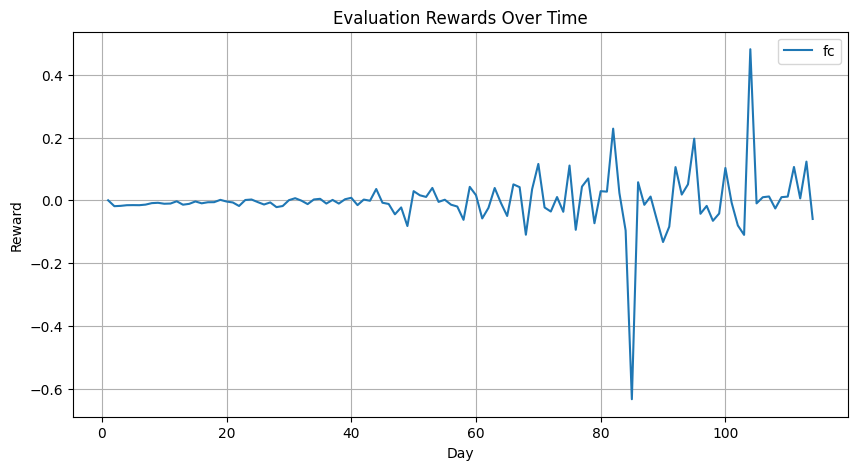

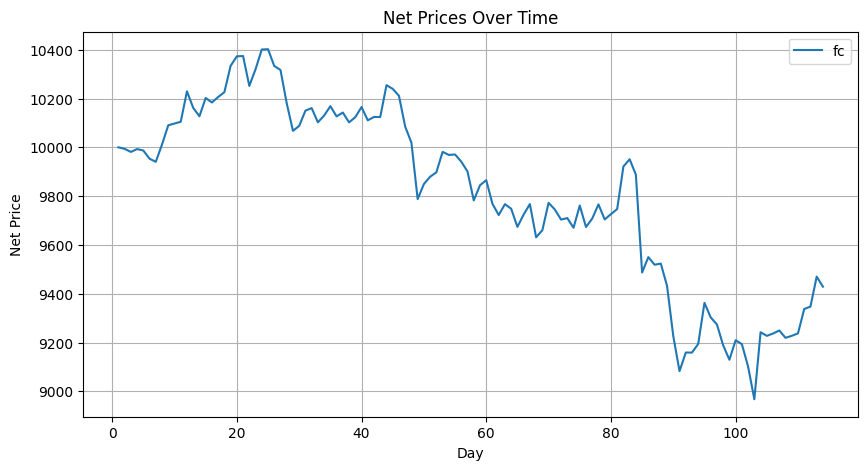

In [ ]:
plt.figure(figsize=(10, 5))
for model, rewards in eval_rewards.items():
    days = range(1, len(rewards) + 1)
    plt.plot(days, rewards, label=model)
plt.xlabel('Day')
plt.ylabel('Reward')
plt.title('Evaluation Rewards Over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for model, net_prices in eval_net_prices.items():
    days = range(1, len(net_prices) + 1)
    plt.plot(days, net_prices, label=model)
plt.xlabel('Day')
plt.ylabel('Net Price')
plt.title('Net Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

Save the model

In [ ]:
checkpoint_path = algo.save()
print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/tmp/tmpkve53wgo), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_kl_coeff': 0.20000000000000004, 'cur_lr': 5.0000000000000016e-05, 'total_loss': 0.15427812041241615, 'policy_loss': 0.0010423221254861482, 'vf_loss': 0.15125605153741054, 'vf_explained_var': 0.08100050469880463, 'kl': 0.009898735451689166, 'entropy': 6.982191945660499, 'entropy_coeff': 0.0}, 'model': {}, 'num_grad_updates_lifetime': 2325.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 12000, 'num_env_steps_trained': 12000, 'num_agent_steps_sampled': 12000, 'num_agent_steps_trained': 12000}, 'env_runners': {'episode_reward_max': 0.6418609621735527, 'episode_reward_min': -2.8349255615506763, 'episode_reward_mean': -1.3822855260278153, 'episode_len_mean': 502.0, 'episode_media': {}, 'episodes_timesteps_total': 11546, 'policy